<a href="https://colab.research.google.com/github/Jhonsep/IMPLEMENTACION_TESIS_DRON/blob/main/training_A2_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrenamiento A2

## Settings

In [ ]:
# ============================================
# ENTRENAMIENTO A2 con STM FIFO (frame a frame)
# - Fase DRONE:    190 frames
# - Fase NODRONE:  90 frames (ruido / imágenes)
# - Fase BLACK:    60 frames (imagen negra sólida)
# - Métrica: CategoricalAccuracy
# - Debugger opcional (VISUALIZE) actualiza frame a frame (rápido)
# ============================================
import os, random, time, glob
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, saving
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# -------------------------
# 0) Montaje Drive (opcional) y ver GPU
# -------------------------
def gpus_available():
    """Devuelve True si hay al menos un dispositivo GPU disponible."""
    gpus = tf.config.list_physical_devices('GPU')
    return len(gpus) > 0

# Uso típico
if gpus_available():
    print("GPU disponible:", tf.config.list_physical_devices('GPU'), "Usando GPU para el entrenamiento.")
else:
     print("No se detectó una GPU. El entrenamiento se ejecutará en la CPU, lo cual será más lento.")

# Montar Google Drive
from google.colab import drive
try:
    drive.mount('/content/drive')
    print("Google Drive montado exitosamente.")
except Exception as e:
    print(f"Error al montar Drive: {e}. Intente recargar la página.")

# Definir la ruta de la carpeta del proyecto DENTRO de Drive
# **ASEGÚRATE DE QUE ESTA RUTA COINCIDA CON LA UBICACIÓN DE TU CARPETA**
RUTA_PROYECTO_DRIVE = '/content/drive/MyDrive/Implementacion_Tesis_Drones'

# Cambiar el directorio de trabajo al proyecto
if os.path.isdir(RUTA_PROYECTO_DRIVE):
    %cd {RUTA_PROYECTO_DRIVE}
    print(f"Directorio de trabajo cambiado a: {os.getcwd()}")
else:
    print(f"Error: La carpeta '{RUTA_PROYECTO_DRIVE}' no fue encontrada.")
    print("Asegúrese de que la carpeta compartida esté en la raíz de su Drive.")



GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] Usando GPU para el entrenamiento.
Mounted at /content/drive
Google Drive montado exitosamente.
/content/drive/MyDrive/Implementacion_Tesis_Drones
Directorio de trabajo cambiado a: /content/drive/MyDrive/Implementacion_Tesis_Drones


## Rutas y parámetros

In [ ]:
# -------------------------
# 1) Rutas y parámetros
# -------------------------
OUTPUT_DIR        = './'
os.makedirs(OUTPUT_DIR, exist_ok=True)

A1_MODEL_PATH     = os.path.join(OUTPUT_DIR, 'A1/models/OTA_drone_model_E3_T2.keras')
A2_SAVE_PATH      = os.path.join(OUTPUT_DIR, 'A2/models/recognizer_dron_model_T1.keras')

DRONE_SINGLE_IMAGE= os.path.join(OUTPUT_DIR, 'images/dron/0029(1).jpg')
NODRONE_DIR       = os.path.join(OUTPUT_DIR, 'images/nodron')
history_csv_path  = os.path.join(OUTPUT_DIR, 'A2/logs/recognizer_dron_model_T1.csv')

# Geometría
INPUT_IMAGE_SIZE = (320, 240)   # (W, H)
ROI_W, ROI_H     = 240, 160
STM_LEN          = 10
OUT_DIM          = 22
MIN_OFFSET       = -5

# Esquema por época
FRAMES_DRONE     = 190   # 120 frames con 'drone'
FRAMES_NODRONE   = 90    # 180 frames no-dron (ruido/imágenes)
FRAMES_BLACK     = 60    #  60 frames negros (no-dron)

TEMPERATURA = 0.25

# Entrenamiento
EPOCHS       = 200
BATCH_SIZE   = 8
LR           = 1e-3
SEED         = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Mezcla dentro de no-dron
P_NOISE_WITHIN_NODRONE = 0.25

# Movimiento suave
DELTA_ANGLE_MAX = 10        # grados
DELTA_SCALE_MAX = 0.10      # ±10%
DELTA_TRANS_MAX = 5         # px por frame (suave)
ANGLE_INIT_RANGE = (-25, 25)
SCALE_INIT_RANGE = (0.35, 1.05)
TRANS_INIT_RANGE = (-10, 10)

# Debug
VISUALIZE = False  # pon True para ver el HUD frame a frame (más lento)

## A1: clase registrable y carga (sin métrica custom)

In [ ]:
# -------------------------
# 2) A1: clase registrable y carga (sin métrica custom)
# -------------------------
@saving.register_keras_serializable(package="MyModels")
class OffsetTrackingAutoencoder(Model):
    def __init__(self, latent_dim, output_dim, input_shape, **kwargs):
        super().__init__(**kwargs)
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        self.input_shape_ = input_shape
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=input_shape),
            layers.Flatten(),
            layers.Dense(self.latent_dim, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([ layers.Dense(self.output_dim, activation='sigmoid') ])
    def build(self, input_shape):
        self.input_shape_ = input_shape
        self.encoder.build(input_shape)
        inter = self.encoder.compute_output_shape(input_shape)
        self.decoder.build(inter)
        super().build(input_shape)
    def call(self, x):
        return self.decoder(self.encoder(x))
    def get_config(self):
        cfg = super().get_config()
        cfg.update({'latent_dim': self.latent_dim, 'output_dim': self.output_dim, 'input_shape': self.input_shape_[1:]})
        return cfg
    @classmethod
    def from_config(cls, config):
        inp = config.pop('input_shape', None)
        return cls(input_shape=inp, **config)

print("\nCargando A1...")
autoencoder_drone = tf.keras.models.load_model(
    A1_MODEL_PATH,
    compile=False,
    custom_objects={'OffsetTrackingAutoencoder': OffsetTrackingAutoencoder}
)
print("A1 OK.")

@tf.function
def tf_infer_a1(x):
    return autoencoder_drone(x, training=False)

# pre-warm
_ = tf_infer_a1(tf.constant(np.zeros((1, ROI_H, ROI_W, 1), dtype=np.float32)))

autoencoder_drone.summary()


Cargando A1...
A1 OK.


Model: "offset_tracking_autoencoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 51)             │     1,958,451 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 22)             │         1,144 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,959,595 (7.48 MB)

 Trainable params: 1,959,595 (7.48 MB)

 Non-trainable params: 0 (0.00 B)

## A2: definición + compile con CategoricalAccuracy

In [ ]:
# -------------------------
# 3) A2: definición (MLP) + compile con CategoricalAccuracy
# -------------------------
@saving.register_keras_serializable(package="MyModels")
class Recognizer(Model):
    def __init__(self, dense_units, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.dense_units = dense_units
        self.dropout_rate = dropout_rate
        self.flatten = layers.Flatten()
        self.d1 = layers.Dense(self.dense_units, activation='relu')
        self.do = layers.Dropout(self.dropout_rate) if self.dropout_rate>0 else None
        self.out = layers.Dense(2, activation='softmax', dtype='float32')

    def build(self, input_shape):
        self.flatten.build(input_shape)
        flat = self.flatten.compute_output_shape(input_shape)
        self.d1.build(flat)
        nxt = self.d1.compute_output_shape(flat)
        if self.do:
            self.do.build(nxt); nxt = self.do.compute_output_shape(nxt)
        self.out.build(nxt)
        super().build(input_shape)

    def call(self, x, training=False):
        x = self.flatten(x)
        x = self.d1(x)
        if self.do:
            x = self.do(x, training=training)
        return self.out(x)
    def get_config(self):
        return {**super().get_config(), 'dense_units': self.dense_units, 'dropout_rate': self.dropout_rate}
    @classmethod
    def from_config(cls, config):
        return cls(**config)

recognizer = Recognizer(dense_units=37, dropout_rate=0.2)

recognizer.compile(optimizer=keras.optimizers.Adam(LR),
                   loss='categorical_crossentropy',
                   metrics=[keras.metrics.CategoricalAccuracy(name='categorical_accuracy')])
recognizer.build(input_shape=(None, STM_LEN, OUT_DIM))
recognizer.summary()

Model: "recognizer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 220)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 37)             │         8,177 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,253 (32.24 KB)

 Trainable params: 8,253 (32.24 KB)

 Non-trainable params: 0 (0.00 B)

## Utils: E/S, Canny, augment, ROI, temperatura

In [ ]:
# -------------------------
# 4) Utils: E/S, Canny, augment, ROI, temperatura
# -------------------------
def load_gray_norm(path):
    img = cv2.imread(path)
    if img is None:
        return None
    img = cv2.resize(img, INPUT_IMAGE_SIZE)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray.astype(np.float32)/255.0

def compute_canny_norm(img_gray_norm):
    im_u8 = (img_gray_norm * 255).astype(np.uint8)
    return cv2.Canny(im_u8, 50, 150).astype(np.float32) / 255.0

def crop_roi(edges_norm, center_xy):
    cx, cy = int(center_xy[0]), int(center_xy[1])
    x0 = max(0, cx - ROI_W//2); y0 = max(0, cy - ROI_H//2)
    x1 = min(INPUT_IMAGE_SIZE[0], x0 + ROI_W); y1 = min(INPUT_IMAGE_SIZE[1], y0 + ROI_H)
    roi = edges_norm[y0:y1, x0:x1]
    if roi.shape[0]!=ROI_H or roi.shape[1]!=ROI_W:
        roi = cv2.resize(roi, (ROI_W, ROI_H), interpolation=cv2.INTER_AREA)
    return roi

class SmoothMotionState:
    def __init__(self, angle_range=ANGLE_INIT_RANGE, scale_range=SCALE_INIT_RANGE, trans_range=TRANS_INIT_RANGE):
        self.angle = float(random.uniform(*angle_range))
        self.scale = float(random.uniform(*scale_range))
        self.tx = float(random.uniform(*trans_range))
        self.ty = float(random.uniform(*trans_range))
    def step(self):
        self.angle += random.uniform(-DELTA_ANGLE_MAX, DELTA_ANGLE_MAX)
        self.angle = float(np.clip(self.angle, ANGLE_INIT_RANGE[0], ANGLE_INIT_RANGE[1]))
        self.scale *= (1.0 + random.uniform(-DELTA_SCALE_MAX, DELTA_SCALE_MAX))
        self.scale = float(np.clip(self.scale, SCALE_INIT_RANGE[0], SCALE_INIT_RANGE[1]))
        self.tx += random.uniform(-DELTA_TRANS_MAX, DELTA_TRANS_MAX)
        self.tx = float(np.clip(self.tx, TRANS_INIT_RANGE[0], TRANS_INIT_RANGE[1]))
        self.ty += random.uniform(-DELTA_TRANS_MAX, DELTA_TRANS_MAX)
        self.ty = float(np.clip(self.ty, TRANS_INIT_RANGE[0], TRANS_INIT_RANGE[1]))

def transform_edges_from_gray(base_gray_norm, motion: SmoothMotionState):
    H, W = base_gray_norm.shape[:2]
    edges0 = compute_canny_norm(base_gray_norm)  # 0..1 float
    e_u8 = (edges0 * 255).astype(np.uint8)

    cx, cy = W//2, H//2
    M_rot = cv2.getRotationMatrix2D((cx, cy), motion.angle, 1.0)
    rot = cv2.warpAffine(e_u8, M_rot, (W, H), flags=cv2.INTER_LINEAR,
                         borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    new_w = max(1, int(round(W * motion.scale)))
    new_h = max(1, int(round(H * motion.scale)))
    content = cv2.resize(rot, (new_w, new_h),
                         interpolation=cv2.INTER_AREA if motion.scale < 1.0 else cv2.INTER_LINEAR)
    canvas = np.zeros((H, W), dtype=np.uint8)

    start_x = int((W - new_w) // 2 + motion.tx)
    start_y = int((H - new_h) // 2 + motion.ty)
    dst_x0 = max(0, start_x); dst_y0 = max(0, start_y)
    dst_x1 = min(W, start_x + new_w); dst_y1 = min(H, start_y + new_h)
    src_x0 = max(0, -start_x); src_y0 = max(0, -start_y)
    src_x1 = src_x0 + (dst_x1 - dst_x0); src_y1 = src_y0 + (dst_y1 - dst_y0)
    if dst_x1 > dst_x0 and dst_y1 > dst_y0:
        canvas[dst_y0:dst_y1, dst_x0:dst_x1] = content[src_y0:src_y1, src_x0:src_x1]

    return canvas.astype(np.float32)/255.0

def softmax_temp(logits, T=0.6):
    z = np.asarray(logits, dtype=np.float32) / max(T, 1e-6)
    z -= np.max(z)  # estabilidad numérica
    e = np.exp(z)
    return e / (np.sum(e) + 1e-8)

def normalize_a1_pred_with_temperature(pred22, T=0.6):
    px_probs = softmax_temp(pred22[:11], T=T)
    py_probs = softmax_temp(pred22[11:], T=T)
    return np.concatenate([px_probs, py_probs], axis=0), px_probs, py_probs

def offsets_vector(min_offset=-5, n=11):
    return np.arange(min_offset, min_offset+n, dtype=np.float32)

def center_xy():
    return (INPUT_IMAGE_SIZE[0]//2, INPUT_IMAGE_SIZE[1]//2)


## Fuentes no-dron

In [ ]:
# -------------------------
# 5) Fuentes no-dron
# -------------------------
drone_base = load_gray_norm(DRONE_SINGLE_IMAGE)
if drone_base is None:
    raise SystemExit(f"No se pudo cargar la imagen dron: {DRONE_SINGLE_IMAGE}")
nodrone_paths = glob.glob(os.path.join(NODRONE_DIR, '*'))

def sample_nodrone_gray():
    if random.random() < P_NOISE_WITHIN_NODRONE:
        # ruido (brillante para forzar bordes; ajusta si prefieres uniforme)
        return (np.random.randint(216,256,(INPUT_IMAGE_SIZE[1], INPUT_IMAGE_SIZE[0]), dtype=np.uint8).astype(np.float32)/255.0)
    if not nodrone_paths:
        return (np.random.randint(0,256,(INPUT_IMAGE_SIZE[1], INPUT_IMAGE_SIZE[0]), dtype=np.uint8).astype(np.float32)/255.0)
    p = random.choice(nodrone_paths)
    g = load_gray_norm(p)
    if g is None:
        return (np.random.randint(0,256,(INPUT_IMAGE_SIZE[1], INPUT_IMAGE_SIZE[0]), dtype=np.uint8).astype(np.float32)/255.0)
    return g


## Debug HUD (A1 offsets -5..5, STM con new→left, A2 con truth marker)

In [ ]:
# -------------------------
# 6) Debug HUD (A1 offsets -5..5, STM con new→left, A2 con truth marker)
# -------------------------
offset_ticks = list(range(MIN_OFFSET, MIN_OFFSET+11))  # [-5..5]

def debug_plot(roi_img, px_probs, py_probs, stm, a2_probs, title, epoch, total_epochs, true_lbl, motion_d):
    clear_output(wait=True)
    fig = plt.figure(figsize=(14,6))
    gs = fig.add_gridspec(2,4, width_ratios=[1.1, 1.1, 1.6, 1.0])

    # ROI
    ax_roi = fig.add_subplot(gs[:,0])
    ax_roi.imshow(roi_img, cmap='gray', vmin=0, vmax=1)
    ax_roi.set_title('ROI → A1')
    if motion_d is not None:
        ax_roi.set_xlabel(f'θ={motion_d.angle:.2f}°, scale={motion_d.scale:.2f}, tx={motion_d.tx:.2f}, ty={motion_d.ty:.2f}')

    # A1-X
    ax_x = fig.add_subplot(gs[0,1])
    ax_x.bar(offset_ticks, px_probs)
    ax_x.set_ylim(0,1); ax_x.set_xlim(MIN_OFFSET-0.5, MIN_OFFSET+10.5)
    ax_x.set_title('A1 - X (offsets)'); ax_x.set_xticks(offset_ticks); ax_x.grid(True, alpha=0.2)

    # A1-Y
    ax_y = fig.add_subplot(gs[1,1])
    ax_y.bar(offset_ticks, py_probs)
    ax_y.set_ylim(0,1); ax_y.set_xlim(MIN_OFFSET-0.5, MIN_OFFSET+10.5)
    ax_y.set_title('A1 - Y (offsets)'); ax_y.set_xticks(offset_ticks); ax_y.grid(True, alpha=0.2)

    # STM heatmap (new → left, old → right)
    ax_stm = fig.add_subplot(gs[:,2])
    stm_plot = np.flip(stm, axis=0)  # invierte eje tiempo → nuevo queda en la izquierda
    im = ax_stm.imshow(stm_plot.T, aspect='auto', interpolation='nearest', origin='lower')
    yticks = list(range(22))
    yticklabels = [-5 + (i % 11) for i in range(22)]
    ax_stm.set_yticks(yticks); ax_stm.set_yticklabels(yticklabels)
    ax_stm.set_title('STM (22×10)^T  — Tiempo (new → old)')
    ax_stm.set_xlabel('← new     old →')
    fig.colorbar(im, ax=ax_stm, fraction=0.046, pad=0.04)

    # A2: barras + truth marker
    ax_bar = fig.add_subplot(gs[:,3])
    x_pos = np.arange(2)
    ax_bar.bar(x_pos, [float(a2_probs[0]), float(a2_probs[1])],
               tick_label=['Drone','NoDrone'])
    ax_bar.set_ylim(0,1); ax_bar.set_title('Salida A2 (prob.)'); ax_bar.grid(True, axis='y', alpha=0.3)
    true_idx = int(np.argmax(true_lbl))  # 0=Drone, 1=NoDrone
    ax_bar.plot([true_idx, true_idx], [0, 1], linewidth=1.0, color='k', alpha=0.5)
    ax_bar.plot(true_idx, 1.0, marker='o', markersize=8,
                markerfacecolor='none', markeredgecolor='k', linewidth=1.2)

    plt.suptitle(f'{title}  —  Época {epoch}/{total_epochs}', fontsize=11)
    plt.tight_layout(); plt.show()


## Entrenamiento FIFO con 3 fases (Drone → NoDrone → Black)

Época 200/200  —  loss_avg=0.1301  acc_avg=0.9538


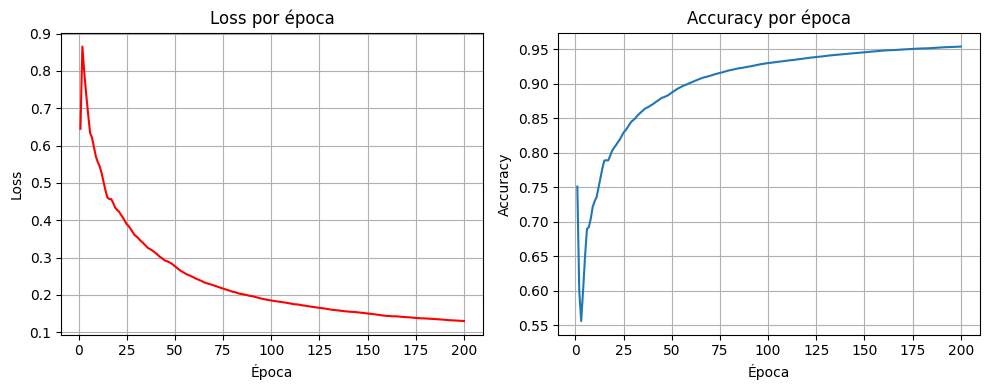

Historial por época guardado en: ./A2/logs/recognizer_dron_model_T1_epoch.csv

Entrenamiento completado. A2 guardado en: ./A2/models/recognizer_dron_model_T1.keras


In [ ]:
# -------------------------
# 7) Entrenamiento FIFO con 3 fases (Drone → NoDrone → Black)
# -------------------------
def make_label(drone=True):
    return np.array([1.,0.], dtype=np.float32) if drone else np.array([0.,1.], dtype=np.float32)

def push_and_maybe_train(batch_X, batch_y):
    if len(batch_X) >= BATCH_SIZE:
        Xb = np.array(batch_X[:BATCH_SIZE], dtype=np.float32)
        yb = np.array(batch_y[:BATCH_SIZE], dtype=np.float32)
        metrics = recognizer.train_on_batch(Xb, yb)
        del batch_X[:BATCH_SIZE]; del batch_y[:BATCH_SIZE]
        return float(metrics[0]), float(metrics[1])
    return None, None

history = []  # (step, loss, acc)
global_step = 0
# --- LOG por ÉPOCA ---
epoch_log = {'epoch': [], 'loss': [], 'acc': []}


for epoch in range(1, EPOCHS+1):
    print(f"\n--- Época {epoch}/{EPOCHS} ---")
    stm_buffer = []
    batch_X, batch_y = [], []
    epoch_loss_acc = []
    motion_d = SmoothMotionState()

    # ----- Fase DRONE -----
    for f in range(FRAMES_DRONE):
        edges = transform_edges_from_gray(drone_base, motion_d)
        roi   = crop_roi(edges, center_xy())
        pred_raw = tf_infer_a1(tf.constant(roi.reshape(1,ROI_H,ROI_W,1), dtype=tf.float32)).numpy()[0]

        # Normalizar con temperatura y alimentar STM
        pred_norm, px_probs, py_probs = normalize_a1_pred_with_temperature(pred_raw, T=TEMPERATURA)

        stm_buffer.append(pred_norm.astype(np.float32))
        if len(stm_buffer) > STM_LEN: stm_buffer.pop(0)

        if len(stm_buffer) == STM_LEN:
            stm_mat = np.stack(stm_buffer, axis=0)
            batch_X.append(stm_mat); batch_y.append(make_label(True))

            if VISUALIZE:
                probs = recognizer.predict(stm_mat[np.newaxis,...], verbose=0)[0]
                debug_plot(roi, px_probs, py_probs, stm_mat, probs,
                           title=f'DRONE  f={f+1}/{FRAMES_DRONE}',
                           epoch=epoch, total_epochs=EPOCHS,
                           true_lbl=np.array([1.,0.], dtype=np.float32),
                           motion_d=motion_d)

            loss, acc = push_and_maybe_train(batch_X, batch_y)
            if loss is not None:
                global_step += 1
                history.append((global_step, loss, acc))
                epoch_loss_acc.append((loss, acc))
                print(f"\r[DRONE] step {global_step}: loss={loss:.4f} acc={acc:.4f}", end='')

        motion_d.step()

    # ----- Fase NO-DRON -----
    for f in range(FRAMES_NODRONE):
        base  = sample_nodrone_gray()
        edges = compute_canny_norm(base)
        roi   = crop_roi(edges, center_xy())
        pred_raw = tf_infer_a1(tf.constant(roi.reshape(1,ROI_H,ROI_W,1), dtype=tf.float32)).numpy()[0]

        pred_norm, px_probs, py_probs = normalize_a1_pred_with_temperature(pred_raw, T=TEMPERATURA)

        stm_buffer.append(pred_norm.astype(np.float32))
        if len(stm_buffer) > STM_LEN: stm_buffer.pop(0)

        if len(stm_buffer) == STM_LEN:
            stm_mat = np.stack(stm_buffer, axis=0)
            batch_X.append(stm_mat); batch_y.append(make_label(False))

            if VISUALIZE:
                probs = recognizer.predict(stm_mat[np.newaxis,...], verbose=0)[0]
                debug_plot(roi, px_probs, py_probs, stm_mat, probs,
                           title=f'NO-DRON  f={f+1}/{FRAMES_NODRONE}',
                           epoch=epoch, total_epochs=EPOCHS,
                           true_lbl=np.array([0.,1.], dtype=np.float32),
                           motion_d=None)

            loss, acc = push_and_maybe_train(batch_X, batch_y)
            if loss is not None:
                global_step += 1
                history.append((global_step, loss, acc))
                epoch_loss_acc.append((loss, acc))
                print(f"\r[NO-DRON] step {global_step}: loss={loss:.4f} acc={acc:.4f}", end='')

    # ----- Fase BLACK (imagen completamente negra) -----
    for f in range(FRAMES_BLACK):
        black = np.zeros((INPUT_IMAGE_SIZE[1], INPUT_IMAGE_SIZE[0]), dtype=np.float32)  # 0..1
        edges = compute_canny_norm(black)  # será todo cero
        roi   = crop_roi(edges, center_xy())
        pred_raw = tf_infer_a1(tf.constant(roi.reshape(1,ROI_H,ROI_W,1), dtype=tf.float32)).numpy()[0]

        pred_norm, px_probs, py_probs = normalize_a1_pred_with_temperature(pred_raw, T=TEMPERATURA)

        stm_buffer.append(pred_norm.astype(np.float32))
        if len(stm_buffer) > STM_LEN: stm_buffer.pop(0)

        if len(stm_buffer) == STM_LEN:
            stm_mat = np.stack(stm_buffer, axis=0)
            batch_X.append(stm_mat); batch_y.append(make_label(False))  # BLACK = NoDrone

            if VISUALIZE:
                probs = recognizer.predict(stm_mat[np.newaxis,...], verbose=0)[0]
                debug_plot(roi, px_probs, py_probs, stm_mat, probs,
                           title=f'BLACK  f={f+1}/{FRAMES_BLACK}',
                           epoch=epoch, total_epochs=EPOCHS,
                           true_lbl=np.array([0.,1.], dtype=np.float32),
                           motion_d=None)

            loss, acc = push_and_maybe_train(batch_X, batch_y)
            if loss is not None:
                global_step += 1
                history.append((global_step, loss, acc))
                epoch_loss_acc.append((loss, acc))
                print(f"\r[BLACK] step {global_step}: loss={loss:.4f} acc={acc:.4f}", end='')

    # Vaciar lote pendiente al final de la época
    while len(batch_X) > 0:
        if len(batch_X) >= BATCH_SIZE:
            loss, acc = push_and_maybe_train(batch_X, batch_y)
        else:
            Xb = np.array(batch_X, dtype=np.float32)
            yb = np.array(batch_y, dtype=np.float32)
            metrics = recognizer.train_on_batch(Xb, yb)
            loss, acc = float(metrics[0]), float(metrics[1])
            batch_X.clear(); batch_y.clear()
        global_step += 1
        history.append((global_step, loss, acc))
        epoch_loss_acc.append((loss, acc))
        print(f"\r[FLUSH] step {global_step}: loss={loss:.4f} acc={acc:.4f}", end='')

    # ---- Fin de época: métricas por ÉPOCA + plot (ax[0]=loss, ax[1]=acc) ----
    clear_output(wait=True)
    ep_loss = np.mean([x[0] for x in epoch_loss_acc]) if epoch_loss_acc else np.nan
    ep_acc  = np.mean([x[1] for x in epoch_loss_acc]) if epoch_loss_acc else np.nan
    print(f"Época {epoch}/{EPOCHS}  —  loss_avg={ep_loss:.4f}  acc_avg={ep_acc:.4f}")

    # Guardar en el log por época
    epoch_log['epoch'].append(epoch)
    epoch_log['loss'].append(ep_loss)
    epoch_log['acc'].append(ep_acc)

    # DataFrame por época
    ep_df = pd.DataFrame(epoch_log)

    # Plots: ÉPOCA vs LOSS/ACC (ax[0]=loss, ax[1]=acc)
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    axes[0].plot(ep_df['epoch'], ep_df['loss'], color='red')#, marker='o')
    axes[0].set_title('Loss por época'); axes[0].set_xlabel('Época'); axes[0].set_ylabel('Loss'); axes[0].grid(True)
    axes[1].plot(ep_df['epoch'], ep_df['acc'])#, marker='o')
    axes[1].set_title('Accuracy por época'); axes[1].set_xlabel('Época'); axes[1].set_ylabel('Accuracy'); axes[1].grid(True)
    plt.tight_layout(); display(fig); plt.close(fig)

    # (opcional) guarda también el CSV por época
    recognizer.save(A2_SAVE_PATH, include_optimizer=True)
    epoch_history_csv_path = history_csv_path.replace('.csv', '_epoch.csv')
    ep_df.to_csv(epoch_history_csv_path, index=False)
    print(f"Historial por época guardado en: {epoch_history_csv_path}")

print("\nEntrenamiento completado. A2 guardado en:", A2_SAVE_PATH)

## Imagen del dron

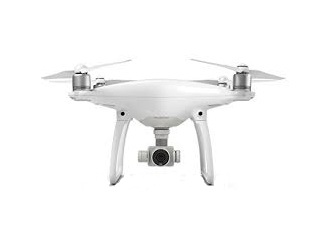

Guarda esta imagen dentro de googledrive y pela ruta en dron single Image